In [35]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

# Machine Learning for Covid Mortality

## Abstract
In this project, we aim to investigate the intricate relationship between different factors and the mortality rate of COVID-19 by employing a range of machine-learning techniques. Our objective is to develop predictive models that not only enhance our understanding of risk factors but also aid public health strategies in mitigating the impact of pandemic. 

## Group Members
- **Kai Luke Holton**
- **Thomas Shou**
- **Omobolade Odedoyin**
- **Dee Velazquez**

## Project Links
Access our complete project code and documentation [here on GitHub](https://github.com/shuyashou/cs475_final_project).

Access our pre-trained models [through web interface](https://cs475project-c17babadc414.herokuapp.com/).

## Introduction
The COVID-19 pandemic has presented unprecedented challenges across the globe, affecting various aspects of life and necessitating robust data analysis to understand and combat the virus effectively. Our project focuses on analyzing case data to predict trends and potential outbreaks using advanced machine learning techniques. This report details our methodologies, findings, and the implications of our work.

We structured our project into several key phases:
1. **Data Collection**: Gathering the latest COVID-19 mortality data from CDC.
2. **Data Cleaning and Preprocessing**: Ensuring data quality and readiness for analysis.
3. **Exploratory Data Analysis (EDA)**: Identifying trends and patterns from the data.
4. **Model Development and Evaluation**: Building and tuning models to predict future case counts and assessing the performance and reliability.
5. **Insights and Recommendations**: Drawing conclusions and providing actionable insights based on our models' outputs.

In the following sections, we delve into each of these areas, presenting our approaches, techniques used, and the outcomes of our analysis.


## Data Collection

### Data Source
Our project utilizes data from the [COVID-19 Case Surveillance Public Use Data](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf/about_data), which is maintained by the Centers for Disease Control and Prevention (CDC). 

### Data Acquisition
We fetch their dataset from their public API, load it into pandas dataframe, drop rows with missing values, and save it as pickle file. The python source code can be access [here](https://github.com/shuyashou/cs475_final_project/blob/main/scripts/download.py).

### Data Dictionary
- `cdc_case_earliest_dt`: The earlier of the Clinical Date (date related to the illness or specimen collection) or the Date Received by CDC.
- `cdc_report_dt`: Date case was first reported to the CDC.
- `pos_spec_dt`: Date of first positive specimen collection.
- `onset_dt`: Symptom onset date.
- `current_status`: Case Status (Case Report Form: What is the current status of this person?)
- `sex`: Sex (Case Report Form)
- `age_group`: Age Groups
- `race_ethnicity_combined`: Race and ethnicity (combined).
- `hosp_yn`: Hospitalization status (Case Report Form: Was the patient hospitalized?)
- `icu_yn`: ICU admission status (Case Report Form: Was the patient admitted to an intensive care unit (ICU)?)
- `death_yn`: Death status (Case Report Form: Did the patient die as a result of this illness?)
- `medcond_yn`: Presence of underlying comorbidity or disease (Case Report Form: Pre-existing medical conditions?)

### Initial Observations
- The dataset contains 106 million rows and 12 columns, each row is a deidentified patient.
- The dataset contains lots of missing/unknown values. 


## Data Cleaning and Preprocessing

### Steps:
1. Drop any row with missing/unknown values. This reduces size of dataset from 106 M to 700 K. (This part handled in the previous data collection part.)
2. Get rid of all columns related to date/time.
3. One-hot encode all categorical variables and keep only one of any column with binary outcome after one-hot encoding. 


In [70]:
df = pd.read_pickle("./cdcdata.pkl")

In [71]:
def one_hot_encode_features(df, columns_to_encode):
    for column in columns_to_encode:
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in DataFrame.")

    df_encoded = pd.get_dummies(df, columns=columns_to_encode)

    return df_encoded

columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No']

df_encoded = one_hot_encode_features(df, columns_to_encode)
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [72]:
df

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Yes,icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
6,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
11,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
30,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
36,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
40,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18336515,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
18336519,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
18336523,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
18336525,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


## Exploratory Data Analysis (EDA)

### Imbalanced class label distribution

death_yn_Yes
False    701401
True      28786
Name: count, dtype: int64
death_yn_Yes
False    0.960577
True     0.039423
Name: count, dtype: float64


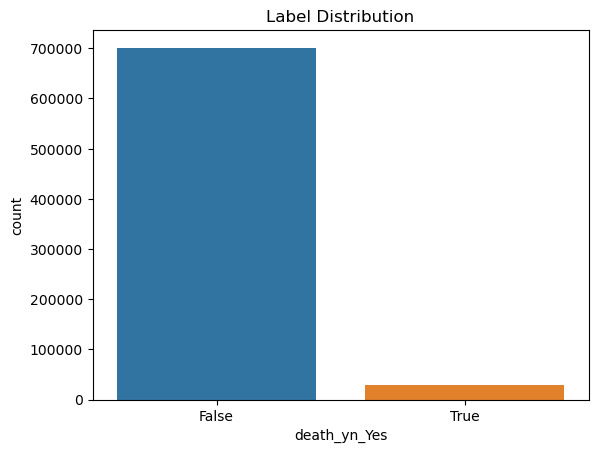

In [73]:
label_counts = df['death_yn_Yes'].value_counts() # death_yn_yes chose as ground truth label
print(label_counts)

label_proportions = label_counts / len(df)
print(label_proportions)


sns.countplot(x=df['death_yn_Yes'])
plt.title('Label Distribution')
plt.show()

## Model Development and Evaluation

### 1. Logistic Regression Model

In [74]:
features = df.drop('death_yn_Yes', axis=1) # death_yn_yes chose as ground truth label
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [75]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### Model Architecture

In [76]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        logits = self.linear(x)
        probabilities = torch.sigmoid(logits) # Output a probability
        return probabilities

In [77]:
def train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        
        for batch_features, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()  
            outputs = model(batch_features) 
            loss = loss_function(outputs.squeeze(), batch_labels.float())  
            loss.backward()  
            optimizer.step()  
            
            running_loss += loss.item() * batch_features.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Evaluation on the validation set
        val_accuracy = evaluate_model(model, val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    print("Training complete")


def evaluate_model(model, data_loader):
    model.eval()  
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():  
        for batch_features, batch_labels in data_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_features) 
            predicted = torch.round(outputs.squeeze())
            correct_predictions += (predicted == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)
    
    accuracy = correct_predictions / total_predictions
    return accuracy

#### Model Training

In [78]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")
    
# Hyperparameters    
input_size = 24
model = LogisticRegressionModel(input_size)
model = model.to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Using GPU: NVIDIA GeForce RTX 4080
Epoch 1/10, Loss: 0.0897, Validation Accuracy: 0.9665
Epoch 2/10, Loss: 0.0818, Validation Accuracy: 0.9668
Epoch 3/10, Loss: 0.0817, Validation Accuracy: 0.9666
Epoch 4/10, Loss: 0.0817, Validation Accuracy: 0.9667
Epoch 5/10, Loss: 0.0818, Validation Accuracy: 0.9665
Epoch 6/10, Loss: 0.0818, Validation Accuracy: 0.9668
Epoch 7/10, Loss: 0.0817, Validation Accuracy: 0.9666
Epoch 8/10, Loss: 0.0817, Validation Accuracy: 0.9665
Epoch 9/10, Loss: 0.0817, Validation Accuracy: 0.9666
Epoch 10/10, Loss: 0.0817, Validation Accuracy: 0.9667
Training complete
Test Accuracy: 0.9676


#### Model Evaluation Using Advanced Metrics
Since we have observed significant class label imbalance within our dataset, with over 96% belong to class 0 (no death), accuracy may not be good enough to truly reflect how well the model performs. Here we introduce ROC-AUC, precision and recall as additional evaluation metrics.

##### ROC-AUC
The ROC curve (Receiver Operating Characteristic curve) plots the true positive rate (recall) against the false positive rate at various threshold settings. The area under this curve (AUC) provides a single measure of a model's performance across all classification thresholds. A model that performs perfectly will have an AUC of 1.0, while a model that makes random guesses will have an AUC of 0.5.

In [79]:
def calculate_roc_score(model, test_loader):
    all_preds = []
    true_labels = []
    model.eval()  
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  

            outputs = model(inputs)

            all_preds.extend(outputs.squeeze().cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    auc_roc_score = roc_auc_score(true_labels, all_preds)
    print(f"AUC-ROC Score: {auc_roc_score:.4f}")

In [80]:
calculate_roc_score(model, test_loader)

AUC-ROC Score: 0.9654


##### PR-AUC
The AUC of the Precision-Recall Curve is typically used to evaluate models on imbalanced datasets where the positive class (the minority class) is of greater interest. A score closer to 1.0 is ideal. Scores closer to 0.5 may not be much better than a random classifier.

In [81]:
def calculate_precision_recall_score(model, test_loader):
    all_preds = []
    true_labels = []
    model.eval()  
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  
            
            outputs = model(inputs)

            probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy()
            all_preds.extend(probabilities)
            true_labels.extend(labels.cpu().numpy())

    precision, recall, _ = precision_recall_curve(true_labels, all_preds)
    auc_pr = auc(recall, precision)
    print(f"Precision-Recall AUC: {auc_pr:.4f}")

In [82]:
calculate_precision_recall_score(model, test_loader)

Precision-Recall AUC: 0.5348


#### 1. Customize Loss Function

Since our model got a low PR AUC score, suggesting the model's discriminative ability has great room for improvement. We want to try replacing the originally used BCELoss function with a customized loss function, with
- weighting mechanism
- additional penalty term for misclassifying minority class instances as majority

In [83]:
def calculate_class_weights(labels):
    class_counts = torch.bincount(labels.long())
    weights = 1. / class_counts.float()
    weights = weights / weights.min()
    return weights

class WeightedBCELoss(torch.nn.Module):
    def __init__(self, weights, penalty_factor=2.0):
        super(WeightedBCELoss, self).__init__()
        self.weights = weights
        self.penalty_factor = penalty_factor

    def forward(self, outputs, targets):
        weights = self.weights.to(outputs.device)
        bce_loss = F.binary_cross_entropy_with_logits(outputs, targets, reduction='none')
        weighted_loss = bce_loss * weights[targets.long()]
        probabilities = torch.sigmoid(outputs)
        predicted_classes = probabilities > 0.5 

        false_negatives = (predicted_classes == 0) & (targets == 1)

        penalties = torch.zeros_like(weighted_loss)
        penalties[false_negatives] = weighted_loss[false_negatives] * self.penalty_factor

        total_loss = weighted_loss + penalties
        return total_loss.mean()

In [84]:
input_size = 24
model = LogisticRegressionModel(input_size)
model = model.to(device)

class_weights = calculate_class_weights(y_train_tensor)
loss_function = WeightedBCELoss(weights=class_weights, penalty_factor=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
calculate_roc_score(model, test_loader)
calculate_precision_recall_score(model, test_loader)

Epoch 1/10, Loss: 1.0673, Validation Accuracy: 0.9131
Epoch 2/10, Loss: 1.0523, Validation Accuracy: 0.9093
Epoch 3/10, Loss: 1.0516, Validation Accuracy: 0.9112
Epoch 4/10, Loss: 1.0523, Validation Accuracy: 0.9132
Epoch 5/10, Loss: 1.0534, Validation Accuracy: 0.9104
Epoch 6/10, Loss: 1.0539, Validation Accuracy: 0.9102
Epoch 7/10, Loss: 1.0544, Validation Accuracy: 0.9084
Epoch 8/10, Loss: 1.0557, Validation Accuracy: 0.9097
Epoch 9/10, Loss: 1.0562, Validation Accuracy: 0.9100
Epoch 10/10, Loss: 1.0564, Validation Accuracy: 0.9104
Training complete
Test Accuracy: 0.9097
AUC-ROC Score: 0.9656
Precision-Recall AUC: 0.5970


#### 2. Balance the class size
The second way we tried to mitigate the negative effect of imbalanced class size is to reduce size of majority class. We randomly sampled a portion of class 0 (no death), and concatenate it with class 1. 
The resulting dataset has a much smaller size.

In [85]:
false_data = df[df['death_yn_Yes'] == 0]  # Majority class
true_data = df[df['death_yn_Yes'] == 1]   # Minority class
undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [86]:
balanced_df

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Yes,icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
17853,True,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
44490,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,False
37735,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
273,False,True,False,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
15598,True,False,True,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
38158,True,False,False,True,False,False,False,False,True,False,...,False,True,False,False,False,False,True,True,True,True
860,True,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
15795,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False


In [87]:
features = balanced_df.drop('death_yn_Yes', axis=1)
labels = balanced_df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 # Use a smaller batch size for smaller dataset

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [88]:
input_size = 24
model = LogisticRegressionModel(input_size)
model = model.to(device)

class_weights = calculate_class_weights(y_train_tensor)
loss_function = WeightedBCELoss(weights=class_weights, penalty_factor=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
calculate_roc_score(model, test_loader)
calculate_precision_recall_score(model, test_loader)

Epoch 1/10, Loss: 0.5822, Validation Accuracy: 0.9177
Epoch 2/10, Loss: 0.5540, Validation Accuracy: 0.9192
Epoch 3/10, Loss: 0.5512, Validation Accuracy: 0.9177
Epoch 4/10, Loss: 0.5500, Validation Accuracy: 0.9196
Epoch 5/10, Loss: 0.5493, Validation Accuracy: 0.9185
Epoch 6/10, Loss: 0.5489, Validation Accuracy: 0.9198
Epoch 7/10, Loss: 0.5486, Validation Accuracy: 0.9184
Epoch 8/10, Loss: 0.5484, Validation Accuracy: 0.9184
Epoch 9/10, Loss: 0.5482, Validation Accuracy: 0.9196
Epoch 10/10, Loss: 0.5482, Validation Accuracy: 0.9182
Training complete
Test Accuracy: 0.9059
AUC-ROC Score: 0.9617
Precision-Recall AUC: 0.9499


#### 3. Feature Importance Measurement and Ablation


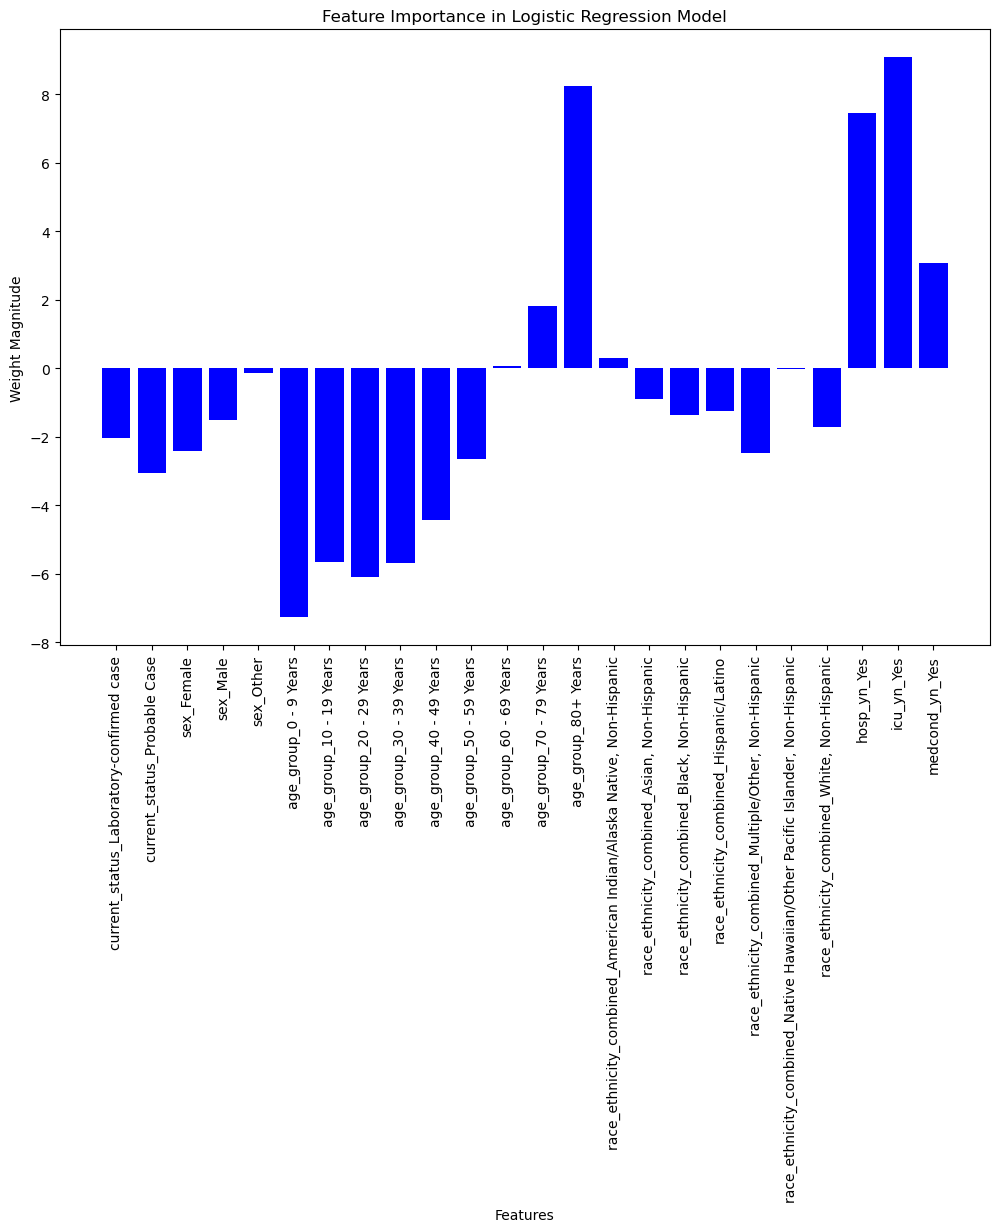

In [89]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Yes', 'icu_yn_Yes', 'medcond_yn_Yes']
weights = model.linear.weight.data.cpu().numpy().flatten()
bias = model.linear.bias.data.cpu().numpy() 
    
plt.figure(figsize=(12, 8))
plt.bar(feature_names, weights, color='b')
plt.xlabel('Features')
plt.ylabel('Weight Magnitude')
plt.title('Feature Importance in Logistic Regression Model')
plt.xticks(rotation=90)
plt.show()

##### Re-train the model with icu condition feature being removed

In [90]:
df = pd.read_pickle("./cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encode_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

false_data = df[df['death_yn_Yes'] == 0]  # Majority class
true_data = df[df['death_yn_Yes'] == 1]   # Minority class
undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [91]:
features = balanced_df.drop('death_yn_Yes', axis=1)
labels = balanced_df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 # Use a smaller batch size for smaller dataset

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [92]:
input_size = 23
model = LogisticRegressionModel(input_size)
model = model.to(device)

class_weights = calculate_class_weights(y_train_tensor)
loss_function = WeightedBCELoss(weights=class_weights, penalty_factor=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
calculate_roc_score(model, test_loader)
calculate_precision_recall_score(model, test_loader)

Epoch 1/10, Loss: 0.5901, Validation Accuracy: 0.9113
Epoch 2/10, Loss: 0.5613, Validation Accuracy: 0.9144
Epoch 3/10, Loss: 0.5575, Validation Accuracy: 0.9161
Epoch 4/10, Loss: 0.5561, Validation Accuracy: 0.9163
Epoch 5/10, Loss: 0.5553, Validation Accuracy: 0.9159
Epoch 6/10, Loss: 0.5549, Validation Accuracy: 0.9166
Epoch 7/10, Loss: 0.5545, Validation Accuracy: 0.9166
Epoch 8/10, Loss: 0.5543, Validation Accuracy: 0.9166
Epoch 9/10, Loss: 0.5542, Validation Accuracy: 0.9156
Epoch 10/10, Loss: 0.5541, Validation Accuracy: 0.9156
Training complete
Test Accuracy: 0.9029
AUC-ROC Score: 0.9477
Precision-Recall AUC: 0.9189


### 2. Random Forest Model
### PLACEHOLDER

## Insights and Recommendations

In [95]:
model_names = ['Naive LR', 'LR with customized loss function']
accuracies = [0.9676, 0.9097]
roc_scores = [0.9654, 0.9656]
pr_scores = [0.5348, 0.5970 ]

# Create a DataFrame
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'ROC AUC': roc_scores,
    'PR AUC': pr_scores
})

In [94]:
results_df

,Model,Accuracy,ROC AUC,PR AUC
0,Naive LR,0.9676,0.9654,0.5348
1,LR with customized loss function,0.9097,0.9656,0.5970


### Conclusion:
Replacing the original binary entropy loss with a customized loss function which takes negative true into account, improves the precision-recall score from 0.53 to 0.59 while remains ROC score. It suggests the model's ability of discriminate between positive and negative class improves. We also observed that the less important metric accuracy dropped a bit (not significantly), which is acceptable because we are prioritizing identifying high death likelihood over overall classification correctness.

In [99]:
model_names = ['LR trained with whole dataset', 'LR trained with smaller dataset', 'LR trained after dominant feature removal']
accuracies = [0.9097, 0.9059, 0.9029]
roc_scores = [0.9656, 0.9617, 0.9477]
pr_scores = [0.5970, 0.9499, 0.9189 ]

# Create a DataFrame
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'ROC AUC': roc_scores,
    'PR AUC': pr_scores
})

In [100]:
results_df

,Model,Accuracy,ROC AUC,PR AUC
0,LR trained with whole dataset,0.9097,0.9656,0.5970
1,LR trained with smaller dataset,0.9059,0.9617,0.9499
2,LR trained after dominant feature removal,0.9029,0.9477,0.9189


### Conclusion:
Training the model with even number of class label (~ 28,000 true and 28,000 false) solve the data imbalance at the expense of much less amount of available training data. The precision-recall score improves a lot from 0.59 to 0.95, while ROC and accuracy remains around same. 
Training the model after the most dominant feature `icu_yn` being removed, we observed a very tiny drop in model's performance among 3 metrics, which shows the original model was not relying too much on that feature when making prediction. This indicates the model's great robustness.

After all the experiments, we identify the model with customized loss function trained with even class label dataset as the best performing one, and you will be able to use that model through our [interface](https://cs475project-c17babadc414.herokuapp.com/).